Description of dataset
A bearing has four major parts: inner race, outer race, rolling element and cage. Fault can occur in any of these components. The CWRU data set contains bearing data consisting of inner race fault, outer race fault and ball defect. A baseline (normal) bearing data with no faults is also available. Some data are collected at a sampling frequency of 12 kHz and some other are collected at 48 kHz. In this study, we will only consider data acquired at 48 kHz sampling frequency. The faults have varying fault depths (0.007 inch, 0.014 inch, 0.021 inch). There is also load variation in motor (No load, 1 hp, 2 hp, 3hp). For this study, we will consider all the data with 1 hp external load.

There are 10 classes for this external load (1 hp). The classes are:

C1 : Ball defect (0.007 inch)
C2 : Ball defect (0.014 inch)
C3 : Ball defect (0.021 inch)
C4 : Inner race fault (0.007 inch)
C5 : Inner race fault (0.014 inch)
C6 : Inner race fault (0.021 inch)
C7 : Normal
C8 : Outer race fault (0.007 inch, data collected from 6 O'clock position)
C9 : Outer race fault (0.014 inch, 6 O'clock)
C10 : Outer race fault (0.021 inch, 6 O'clock)

In [27]:
import numpy as np
import pandas as pd

In [28]:
cwru = np.load('CWRU_48k_load_1_CNN_data.npz')

In [29]:
print(cwru.files)

['data', 'labels']


In [5]:

data = cwru['data']
classes = cwru['labels']
print('size of array classes:',classes.shape)
print()
print('size of array data:',data.shape)
print()
print('random classes ',classes)
print()
unique_classes = np.unique(classes)
print('unique labels',unique_classes)

# ENCODING + catogarizing classes acccording to their unique labels  
classes = pd.Categorical(classes, categories=unique_classes).codes
print(classes)

size of array classes: (4600,)

size of array data: (4600, 32, 32)

random classes  ['Ball_007' 'Ball_007' 'Ball_007' ... 'Normal' 'Normal' 'Normal']

unique labels ['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']
[0 0 0 ... 6 6 6]


In [6]:
data[0].shape

(32, 32)

As the data file was originally intended to be used in a deep learning model, each segment had been resized into size . To compute CWT we have to again resize the matrix like shape into an 1D array. As we are considering a total of 4600 segments, after resizing, our data shape becomes .

In [7]:
# resizing data dividing it into  segments inorder to apply wavelet transform
data_resized = np.reshape(data, (4600,1024))

 ...]

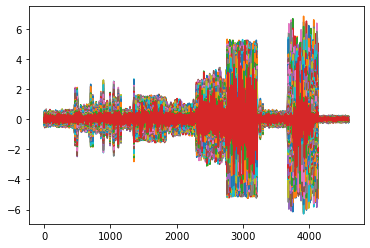

In [8]:
import matplotlib.pylab as plt

plt.plot(data_resized)


In [9]:
np.save('resized_cwru_data', data_resized)

In [10]:
from scipy import signal
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pywt

#wavelet_data = np.repeat(np.nan, repeats = 4600 * 32 * 32)
#wavelet_data = wavelet_data.reshape(-1,32,32)

#width = np.arange(1,2049,step = 32 )
#for i in range(data_resized.shape[0]):
#   coeffecients = pywt.cwt(data_resized[i, :],width,"morl")
#   wavelet_data[i,:,:] = tf.reshape(tf.image.resize(coeffecients.reshape((64, 1024, 1)), (32, 32)), (32, 32))



Following code can be used to compute CWT. The CWT data would be fed into a CNN model that expects input image size to be . Therefore, we resize the output of CWT to a size of .
In mathematics, the Morlet wavelet (or Gabor wavelet) is a wavelet composed of a complex exponential (carrier) multiplied by a Gaussian window (envelope). This wavelet is closely related to human perception, both hearing and vision.

In [11]:
import pywt
import tensorflow as tf

wavelet_data = np.repeat(np.nan, repeats = 4600 * 32 * 32).reshape(-1, 32, 32)
for i in tqdm(range(data_resized.shape[0])):
    segment = data_resized[i, :]
    coefs, _ = pywt.cwt(segment, np.arange(start = 1, stop = 2049, step = 32), "morl")
    wavelet_data[i, :, :] = tf.reshape(tf.image.resize(coefs.reshape((64, 1024, 1)), (32, 32)), (32, 32))

wavelet_data = np.array(wavelet_data)
wavelet_data.shape



100%|██████████| 4600/4600 [11:48<00:00,  6.49it/s]


(4600, 32, 32)

In [12]:
wavelet_data.shape

(4600, 32, 32)

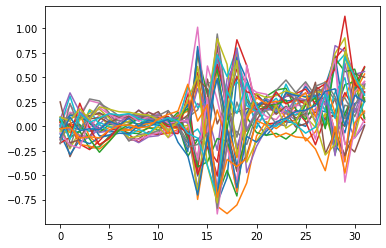

In [13]:
plt.plot(wavelet_data[90])

In [14]:
#Train_data = wavelet_data[0:4000,:,:]
#Train_class = classes[0:4000]
#Validation_data = wavelet_data[4000:4600,:,:]
#Validation_class = classes[4000:4600]


In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



#for cross validation check dividing training data again
data_train, data_test, classes_train, classes_test = train_test_split(wavelet_data,classes, test_size=0.2, random_state=527 , stratify=classes)

#data_train, data_valid, classes_train, classes_valid = train_test_split(data_train,classes_train, test_size=0.2, random_state=125,stratify=classes_train)
print(data_train.shape)
#print(data_valid.shape)
print(classes_train.shape)

(3680, 32, 32)
(3680,)


In [16]:
# reshaping data
data_train = data_train.reshape(-1,32,32,1)
#data_valid = data_valid.reshape(-1,32,32,1)
data_test = data_test.reshape(-1,32,32,1)

from keras.utils import to_categorical
classes_train = to_categorical(classes_train)
classes_test = to_categorical(classes_test)
#classes_valid = to_categorical(classes_valid)

# Shuffling our data
index = np.random.permutation(len(classes_train))
data_train, classes_train = data_train[index], classes_train[index]

print('training data shape: ', data_train.shape)
#print('validation data shape: ', data_valid.shape)
print('testing data shape: ', data_test.shape)
print('training classes shape: ', classes_train.shape)
#print('validation classes shape: ', classes_valid.shape)
print('testing classes shape: ', classes_test.shape)


training data shape:  (3680, 32, 32, 1)
testing data shape:  (920, 32, 32, 1)
training classes shape:  (3680, 10)
testing classes shape:  (920, 10)


In [17]:

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Conv2D, MaxPooling2D, Flatten

In [30]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape = (32,32,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=6, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        36896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)              

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

N_Network = model.fit(data_train , classes_train, epochs=40, batch_size=128, validation_data=(data_test, classes_test))  



Epoch 1/40
29/29 [==============================] - 3s 119ms/step - loss: 1.3569 - accuracy: 0.4818 - val_loss: 0.7296 - val_accuracy: 0.8098
Epoch 2/40
29/29 [==============================] - 3s 118ms/step - loss: 0.4726 - accuracy: 0.8508 - val_loss: 0.3860 - val_accuracy: 0.8565
Epoch 3/40
29/29 [==============================] - 3s 115ms/step - loss: 0.3384 - accuracy: 0.8813 - val_loss: 0.2781 - val_accuracy: 0.9033
Epoch 4/40
29/29 [==============================] - 3s 118ms/step - loss: 0.2326 - accuracy: 0.9299 - val_loss: 0.2142 - val_accuracy: 0.9293
Epoch 5/40
29/29 [==============================] - 3s 115ms/step - loss: 0.1718 - accuracy: 0.9446 - val_loss: 0.1517 - val_accuracy: 0.9587
Epoch 6/40
29/29 [==============================] - 3s 116ms/step - loss: 0.1330 - accuracy: 0.9554 - val_loss: 0.1379 - val_accuracy: 0.9630
Epoch 7/40
29/29 [==============================] - 3s 116ms/step - loss: 0.0973 - accuracy: 0.9677 - val_loss: 0.1332 - val_accuracy: 0.9609
Epoch 

In [32]:
import time

start = time.time()
model.evaluate(data_test,classes_test, batch_size = 128, verbose = 0)
end = time.time()
print(end - start)

0.209442138671875


In [33]:
model.evaluate(data_test,classes_test, batch_size = 128, verbose = 2)


8/8 - 0s - loss: 0.0156 - accuracy: 0.9967


[0.015637855976819992, 0.9967391490936279]

In [22]:
model.save("wavelet.h5")

In [23]:
prediction = model.predict(data_test)
prediction_classes = list([])
for each_prediction in prediction:
    prediction_classes.append(list(each_prediction).index(max(each_prediction)))

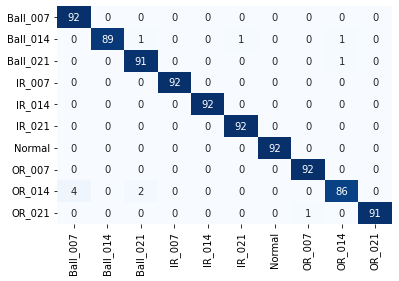

In [24]:
from sklearn.metrics import confusion_matrix
true_classes = np.argmax(classes_test, axis = 1)
matrix = confusion_matrix(true_classes, prediction_classes)

import seaborn as sns
matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = unique_classes,
           yticklabels = unique_classes, cmap = "Blues", cbar = False)
plt.xticks()
plt.show()

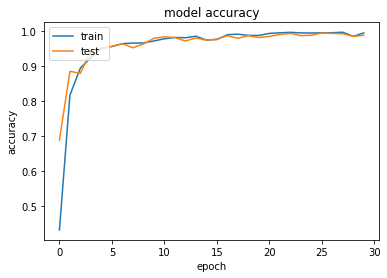

In [25]:
plt.plot(N_Network.history['accuracy'])
plt.plot(N_Network.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

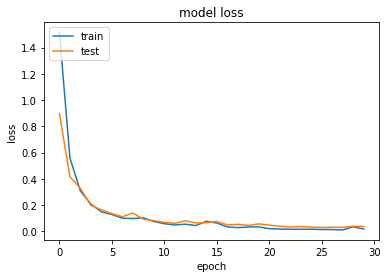

In [26]:
plt.plot(N_Network.history['loss'])
plt.plot(N_Network.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()